# Problem Reserach

1. Mengidentifikasi karakteristik nasabah yang potensial akan mengalami kesulitan dalam mengembalikan pinjaman.
2. Memprediksi kemampuan pembayaran klien.

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest #feature selection
from sklearn.feature_selection import chi2
from sklearn.utils import resample #re-sampling
from sklearn.model_selection import train_test_split #data splitting
from sklearn.preprocessing import StandardScaler #normalize features

from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.naive_bayes import GaussianNB #gaussian naive bayes
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #decision tree
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score #roc score

# Import dataset
application train

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
application_train = pd.read_csv("/content/gdrive/MyDrive/Data Science/Rakamin/VIX - Home Credit/home-credit-default-risk/application_train.csv", sep=',')
print('Terdapat %d baris dan %d kolom.' % application_train.shape)
application_train.head()

Terdapat 307511 baris dan 122 kolom.


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA
Check tipe data

In [ ]:
print('Tipe data: \n')
application_train.info(verbose=True)

Tipe data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int

#Visualisasi

In [ ]:
train = application_train.copy()

In [ ]:
decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
    return decode_map[int(label)]

train['TARGET'] = train['TARGET'].apply(lambda x: decode_sentiment(x))

target_pay = (train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_pay.style.background_gradient(cmap='YlOrBr')

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [ ]:
pay_ability = train['TARGET'].value_counts(normalize=True)
pay_ability.reset_index().style.background_gradient(cmap='YlOrBr')

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


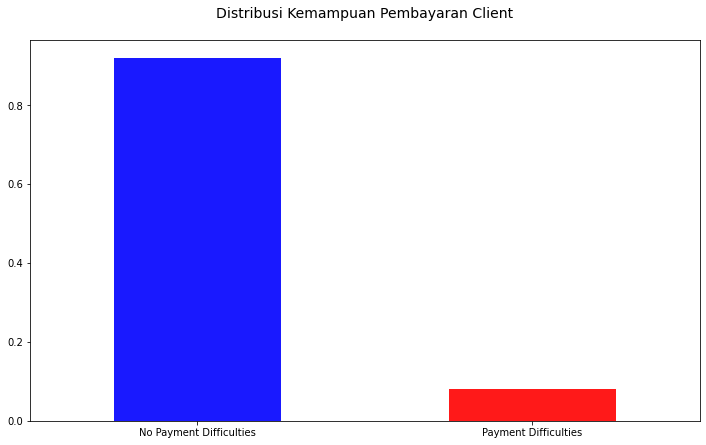

In [ ]:
fig = plt.figure(figsize = (12,7))
pay_ability.plot(kind='bar', color= ['blue','red'], alpha = 0.9, rot=0)
plt.title('Distribusi Kemampuan Pembayaran Client\n', fontsize=14)
plt.show()

Education Type Vs Target

In [ ]:
education_type = train.groupby(by=['NAME_EDUCATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Education Type')
education_type.sort_values(by='SK_ID_CURR', ascending=False)
education_type.style.background_gradient(cmap='YlOrBr')

Clients Repayment Abilities By Education Type


,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR
0,Academic degree,No Payment Difficulties,161
1,Academic degree,Payment Difficulties,3
2,Higher education,No Payment Difficulties,70854
3,Higher education,Payment Difficulties,4009
4,Incomplete higher,No Payment Difficulties,9405
5,Incomplete higher,Payment Difficulties,872
6,Lower secondary,No Payment Difficulties,3399
7,Lower secondary,Payment Difficulties,417
8,Secondary / secondary special,No Payment Difficulties,198867
9,Secondary / secondary special,Payment Difficulties,19524


In [ ]:
application_train[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109277
4,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
1,Higher education,0.053551
0,Academic degree,0.018293


Sejumlah besar aplikasi (218K) diajukan oleh klien dengan pendidikan menengah

Nasabah dengan jenis pendidikan menengah pertama memiliki persentase tertinggi (sekitar 10%) yang mengalami masalah dalam pengembalian pinjaman

# Data Cleaning

Mendeteksi data duplikat

In [ ]:
print('Banyaknyadata duplikat:', application_train.duplicated().sum())
# there is no duplication

Banyaknyadata duplikat: 0


Mendeteksi missing values

In [ ]:
print('Apa ada missing values:', application_train.isnull().values.any())
nvc = pd.DataFrame(application_train.isnull().sum(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/application_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Apa ada missing values: True


,index,Total Null Values,Percentage
0,COMMONAREA_MEDI,214865,69.872297
1,COMMONAREA_AVG,214865,69.872297
2,COMMONAREA_MODE,214865,69.872297
3,NONLIVINGAPARTMENTS_MODE,213514,69.432963
4,NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...,...
117,NAME_HOUSING_TYPE,0,0.000000
118,NAME_FAMILY_STATUS,0,0.000000
119,NAME_EDUCATION_TYPE,0,0.000000
120,NAME_INCOME_TYPE,0,0.000000


# Buang feature yang memiliki banyak missing value (± 50%)

In [ ]:
application_train.drop(application_train.iloc[:, 44:91], inplace=True, axis=1)
application_train.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)
print('Status missing value:', application_train.isnull().values.any())
nvc = pd.DataFrame(application_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/application_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Status missing value: True


,index,Total Null Values,Percentage
0,OCCUPATION_TYPE,96391,31.345545
1,EXT_SOURCE_3,60965,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,41519,13.501631
3,AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.501631
4,AMT_REQ_CREDIT_BUREAU_DAY,41519,13.501631
...,...,...,...
68,FLAG_DOCUMENT_18,0,0.000000
69,FLAG_DOCUMENT_17,0,0.000000
70,FLAG_DOCUMENT_16,0,0.000000
71,FLAG_DOCUMENT_15,0,0.000000


Imputasi missing value dengan median karena data skewness untuk feature numerik
Impurasi missing value dengan modus untuk fitur kategorikal

In [ ]:
category_columns = application_train.select_dtypes(include=['object']).columns.tolist()
integer_columns = application_train.select_dtypes(include=['int64','float64']).columns.tolist()

for column in application_train:
    if application_train[column].isnull().any():
        if(column in category_columns):
            application_train[column]=application_train[column].fillna(application_train[column].mode()[0])
        else:
            application_train[column]=application_train[column].fillna(application_train[column].median())

In [ ]:
print('Apa ada missing value:', application_train.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
nvc = pd.DataFrame(application_train.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = (nvc['Total Null Values']/application_train.shape[0])*100
nvc.sort_values(by=['Percentage'], ascending=False).reset_index()

Apa ada missing value: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
...,...,...,...
68,FLAG_DOCUMENT_20,0,0.0
69,FLAG_DOCUMENT_21,0,0.0
70,AMT_REQ_CREDIT_BUREAU_HOUR,0,0.0
71,AMT_REQ_CREDIT_BUREAU_DAY,0,0.0


# Model Machine Learning

In [ ]:
# label encoder
application_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = application_train[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Feature Selection

In [ ]:
application_train.drop(['SK_ID_CURR'], inplace=True, axis=1)

convert nilai negatif menjadi positif

In [ ]:
application_train.iloc[:,16:20] = application_train.iloc[:,16:20].abs()
application_train.iloc[:,45] = application_train.iloc[:,45].abs()

Feature selection(2)

In [ ]:
x = application_train.drop(['TARGET'], axis=1)
y = application_train['TARGET']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('Feature yang memiliki nilai score yang baik dengan target:\n')
featureScores.sort_values(by=['Score'], ascending=False)

Feature yang memiliki nilai score yang baik dengan target:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
...,...,...
48,FLAG_DOCUMENT_5,3.020010e-02
63,FLAG_DOCUMENT_20,1.425955e-02
65,AMT_REQ_CREDIT_BUREAU_HOUR,1.832008e-03
22,FLAG_CONT_MOBILE,7.863447e-05


Mengatasi imbalance

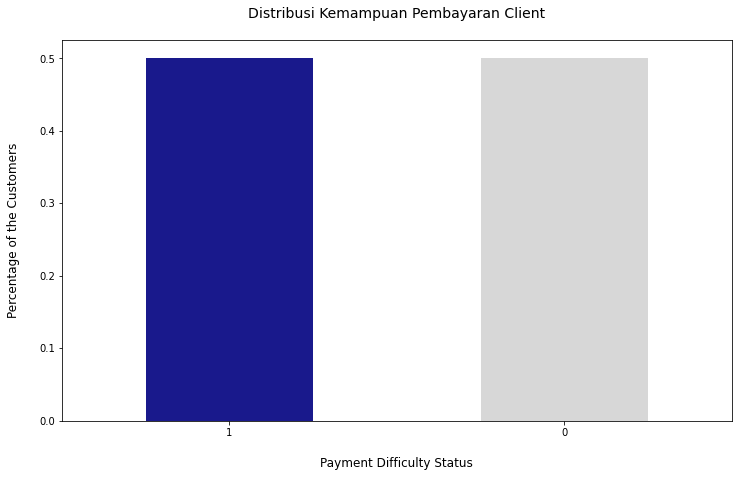

In [ ]:
# buat dua data frame kelas mayoritas dan minoritas yang berbeda
df_majority = application_train[(application_train['TARGET']==0)] 
df_minority = application_train[(application_train['TARGET']==1)] 

# upsample kelas minoritas
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= 282686, 
                                 random_state=42)  

# menggabungkan kelas mayoritas dengan kelas minoritas upsampled
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

fig = plt.figure(figsize = (12,7))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['navy','lightgrey'], alpha = 0.9, rot=0)
plt.title('Distribusi Kemampuan Pembayaran Client\n', fontsize=14)
plt.ylabel('Percentage of the Customers\n', fontsize=12)
plt.xlabel('\nPayment Difficulty Status', fontsize=12)
plt.show()

Split data

In [ ]:
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

# normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

(452297, 20) (113075, 20)


Membentuk model
1. Regresi Logistik
2. Decision Tree

Reglog

In [ ]:
# train model
log_model = LogisticRegression().fit(X_train, y_train)
print(log_model)

# predict data train
y_train_pred_log = log_model.predict(X_train)

# hasil klasifikasi
print(classification_report(y_train, y_train_pred_log))

LogisticRegression()
              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



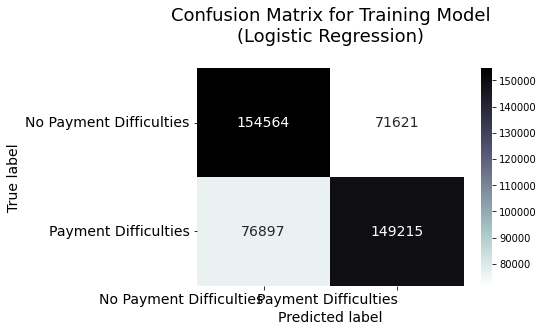

In [ ]:
# confusion matrikx reglog
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
# predict data test
y_test_pred_log = log_model.predict(X_test)

# print classification report
print('Classification Report Testing Model (Logistic Regression):')
print(classification_report(y_test, y_test_pred_log))



Classification Report Testing Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



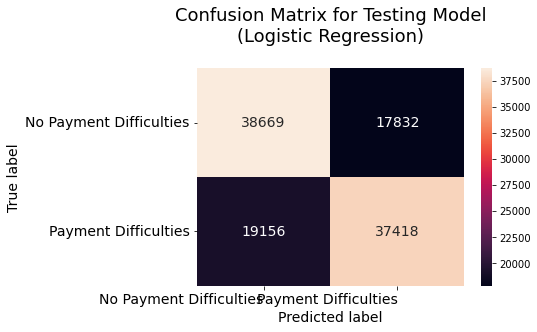

In [ ]:
# form confusion matrix as a dataFrame
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Test Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 67.16
Test Accuracy: % 67.29


In [ ]:
# ROC scores
roc_auc_log = round(roc_auc_score(y_test, y_test_pred_log),4)
print('ROC AUC:', roc_auc_log)

ROC AUC: 0.6729


DT

In [ ]:
# train the model
dt_model = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_model)



DecisionTreeClassifier()


In [ ]:
# predict data test
y_test_pred_dt = dt_model.predict(X_test)

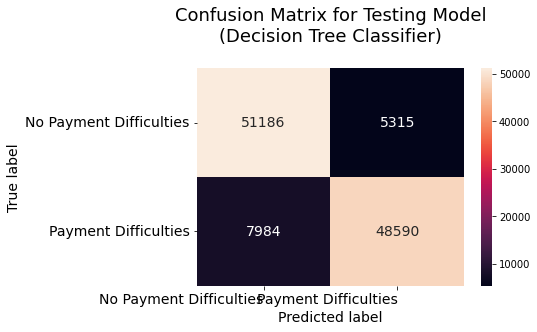

In [ ]:
# form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Testing Model\n(Decision Tree Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [ ]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 88.24


In [ ]:
# ROC scores
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('ROC AUC:', roc_auc_dt)

ROC AUC: 0.8824
